In [1]:
# Step 1. Grab a random assortment of frames from cab_ride_trimmed.py

import cv2
import numpy as np
import random
from tqdm import tqdm

def random_frames_from_video(video_path, num_frames=5):
    """
    Extracts random frames from a video and returns them as a list of NumPy arrays.
    
    Parameters:
        video_path (str): Path to the video file.
        num_frames (int): Number of random frames to extract.
        
    Returns:
        list: List of NumPy arrays representing the frames.
    """
    # Open the video using OpenCV
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Check if the video file was opened successfully
    if not cap.isOpened():
        print("Error: Couldn't open the video file.")
        return []

    frames = []

    for _ in tqdm(range(num_frames)):
        # Get a random frame number
        frame_num = random.randint(0, total_frames - 1)
        # Set the video position to the frame number
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        # Read the frame
        ret, frame = cap.read()

        if ret:
            frames.append(frame)

    # Release the video capture object
    cap.release()
    
    return frames

# Extract random frames from the video
frames = random_frames_from_video('cab_ride_trimmed.mkv', num_frames=1000)

# The 'frames' list now contains 5 randomly extracted frames as NumPy arrays.
# You can process these arrays as needed.


100%|██████████████████████████████████████| 1000/1000 [01:46<00:00,  9.41it/s]


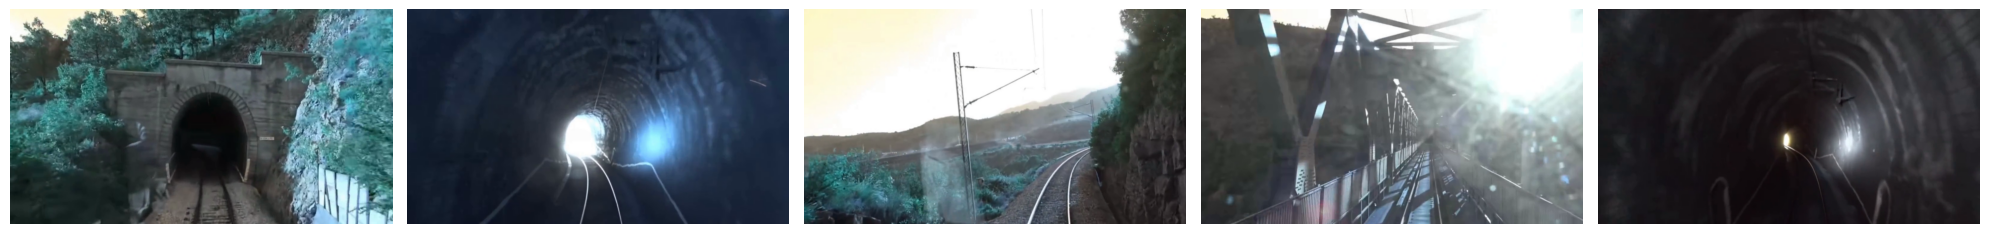

shape: (720, 1280, 3)


In [37]:
# Step 2: preview a random sample of images

import matplotlib.pyplot as plt

# Display up to 5 frames
display_frames = frames[:5]

fig, axs = plt.subplots(1, len(display_frames), figsize=(20, 5))

for ax, frame in zip(axs, display_frames):
    ax.imshow(frame)
    ax.axis('off')

plt.tight_layout()
plt.show()
print("shape:", frames[0].shape)

In [39]:
# Step 3: Get the frames into 1d arrays of pixels
some_frame = frames[0]
print("reshaped frames:", some_frame.reshape(-1, 3))
print("length of the reshaped frames:", len(some_frame.reshape(-1, 3)))

reshaped frames: [[255 250 217]
 [255 250 217]
 [255 250 217]
 ...
 [182 226 244]
 [182 226 244]
 [182 226 244]]
length of the reshaped frames: 921600


In [27]:
reshaped_frames = [frame.reshape(-1, 3) for frame in frames]

In [42]:
print(len(reshaped_frames[0]))

921600


In [44]:
# Step 4: Scramble each of the frames in exactly the same way using numpy's fancy indexing
scrambled_indices = np.random.permutation(len(reshaped_frames[0]))
scrambled_frames = []
for frame in tqdm(reshaped_frames):
    scrambled_frames.append(frame[scrambled_indices])

100%|██████████████████████████████████████| 1000/1000 [00:37<00:00, 26.80it/s]


In [45]:
# Step 5: Create a heuristic to determine the closeness of the pixels


1000